In [1]:
import pandas as pd
import sys
sys.path.append('PATH-TO-CODE/misc/')
from methylpydmr import MethylPyDMR
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import numpy as np
# import anndata
# import mygene


In [2]:
nonn = ''
sp_list = ['Human','Marmoset','Mouse']
sp_fullnames = { 'hs':'human', 'cj':'marmoset', 'mm':'mouse'}


In [3]:
dmrds_list = { sp:MethylPyDMR(f'PATH-TO-ANALYSIS/{sp}/subclass/dmr/subclass_dmr_rms_results_collapsed.tsv') for sp in sp_list }

# dmr numbers

In [4]:
spdf_list = []
sp_hypdmr_count = []
for sp in sp_list:
    df = {}
    dmrcount = {}
    dmrds = dmrds_list[sp]
    for sample in dmrds.samples:
        hypo_bed = dmrds.hypo_bed(sample)
        hyper_bed = dmrds.hyper_bed(sample)
        df[sample] = [-(hypo_bed['end']+250-hypo_bed['start']+250).sum(),
                      (hyper_bed['end']+250-hyper_bed['start']+250).sum()]
        dmrcount[sample] =len(hypo_bed)+len(hyper_bed)
#         df[sample] = [-len(dmrds.hypo_bed(sample)), len(dmrds.hyper_bed(sample))]
    df = pd.DataFrame.from_dict(df)
    df.index=['hypo','hyper']
    df = df.T
    df.columns = pd.MultiIndex.from_product([[sp], df.columns])
    spdf_list.append(df)
    
    dmrcount = pd.DataFrame.from_dict(dmrcount, orient='index', columns=[sp])
    sp_hypdmr_count.append(dmrcount)
    
spdf = pd.concat(spdf_list, axis=1)
spdf.fillna(0, inplace=True)
spdf['sorter'] = spdf[('Human','hyper')]-spdf[('Human','hypo')]
spdf = spdf.sort_values('sorter', ascending=False)
spdf.drop(columns='sorter', inplace=True)

sp_hypdmr_count = pd.concat(sp_hypdmr_count, axis=1)
sp_hypdmr_count = sp_hypdmr_count.fillna(0).astype(int)


/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
samples = spdf.index

In [6]:
sp_countC = {}
for sp in sp_list:
    countC = np.loadtxt(f'PATH-TO-ANALYSIS/{sp}/subclass/countC.rlt', dtype=str)
    countC = pd.DataFrame(countC.reshape(-1,2), columns=['subclass','c_count'])
    countC['subclass'] = countC['subclass'].apply(lambda x: x.split('.')[0])
    countC['c_count'] = countC['c_count'].astype(int)
    countC.set_index('subclass', inplace=True)
    sp_countC[sp] = countC

In [7]:
sample_rename_dict = {'L5_IT':'L5 IT', 'L2_3_IT':'L2/3 IT', 'Lamp5':'Lamp5', 'Pvalb':'Pvalb', 
                     'Vip':'Vip', 'Sst':'Sst', 'L6_CT':'L6 CT', 'L6_IT':'L6 IT', 
                     'Sst_Chodl':'Sst Chodl', 'Sncg':'Sncg', 'L6b':'L6b', 'L6_IT_Car3':'L6 IT Car3', 
                     'L5_6_NP':'L5/6 NP', 'L5_ET':'L5 ET', 'Meis2':'Meis2'}

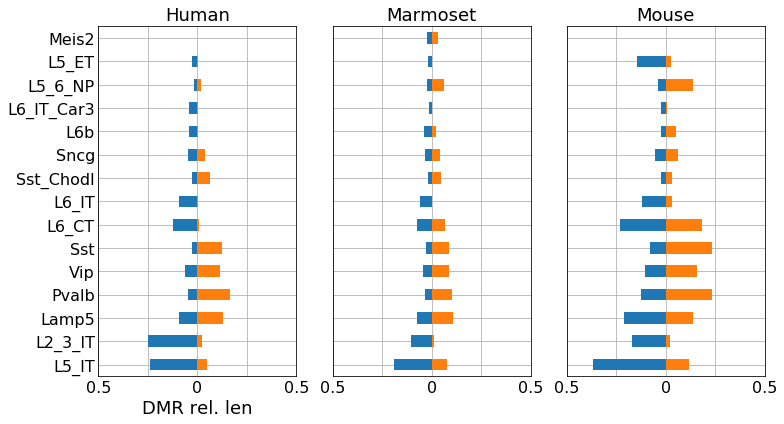

In [8]:
toplot_spdf = spdf.loc[['Meis2','L5_ET', 'L5_6_NP','L6_IT_Car3', 'L6b',  'Sncg','Sst_Chodl', 'L6_IT',  'L6_CT',  'Sst','Vip', 'Pvalb', 'Lamp5', 'L2_3_IT', 'L5_IT'][::-1]]
toplot_dmrcount = (sp_hypdmr_count/1000).round(0).astype(int).loc[['Lamp5', 'Sncg', 'Vip', 'Sst_Chodl', 'Sst', 'Pvalb', 'L2_3_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L5_ET', 'L5_6_NP', 'L6_CT', 'L6b'][::-1]]

fig, axes = plt.subplots(1,3, figsize=(11,6))
for i,sp in enumerate(sp_list):
    countC = sp_countC[sp]
    spdmrnormed = toplot_spdf[sp].apply(lambda x: x/countC.loc[x.name, 'c_count'] if x.name in countC.index else np.nan, axis=1)

    
    spdmrnormed.plot(kind = 'barh', stacked=True, ax=axes[i], legend=sp=='hs',zorder=10)    
    
    axes[i].set_xlim(-0.4, 0.4)
    axes[i].set_title(sp, fontsize=18)

    axes[i].grid(True,zorder=-10)

    axes[i].set_xticks([-0.5,-0.25,0,0.25,0.5])
    axes[i].set_xticklabels([0.5,'',0,'',0.5])

    axes[i].tick_params(labelsize=16, length=0)
    if i!=0:
        axes[i].set_yticklabels([])


        
axes[0].set_xlabel('DMR rel. len', fontsize=18)
plt.tight_layout()
